<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/forward_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pharringtonp19/business-analytics.git

Cloning into 'business-analytics'...
remote: Enumerating objects: 1275, done.
remote: Counting objects: 100% (506/506), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 1275 (delta 412), reused 218 (delta 215), pack-reused 769 (from 3)
Receiving objects: 100% (1275/1275), 21.89 MiB | 18.23 MiB/s, done.
Resolving deltas: 100% (746/746), done.


### **Import Packages**

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import jax.numpy as jnp
import jax
import seaborn as sb
from functools import partial

### **Specify Dataset**

In [3]:
dataset = 'brookline'

### **Read In Data Set**

In [4]:
df = pd.read_csv('/content/business-analytics/datasets/brookline.csv')
df.head()

,price,stNumber,stName,size,beacon,baseFloor,buildingStyle,elevators,rooms,bedrooms,fullBathrooms,halfBathrooms,garage
0,174000,150,PLEASANT ST,1060,0,4,MID-RISE,1,4,2,1,1,1.0
1,337000,7,LEVERETT ST,831,0,1,DECKER,0,4,2,1,0,0.0
2,850000,24,EUSTON ST,2246,0,1,ROW-END,0,10,6,3,0,0.0
3,516000,417,WASHINGTON ST,1574,0,2,LOW-RISE,0,6,3,2,0,0.0
4,145000,150,PLEASANT ST,669,0,4,MID-RISE,1,3,1,1,0,1.0


### **Create Function**

In [5]:
def get_rsqrs(reg_formula):
  linear_model  = smf.ols(reg_formula, df)
  results = linear_model.fit()
  return results.rsquared_adj, results.rsquared

get_rsqrs('price ~ beacon')

(0.0021307532514860394, 0.0030512968370474125)

### **Store Results**

In [6]:
# To Keep Track of Results
ordered_variables = []
optimal_adj_rsqr, optimal_rsqr = [], []

**Specify the dependent variable**

In [7]:
dep_var = 'price'

**Create list of possible Right Hand Side Variables**

In [8]:
eligible_vars = df.columns.drop(['stNumber', 'stName', dep_var]).tolist()
categorical_vars = ['buildingStyle']

### **Create Dictionary of Variable Name and Regression String Format**

In [14]:
eligible_vars_rep = {key: key if key not in categorical_vars else f'C({key})' for key in eligible_vars}

### **Create Regression String**

In [10]:
reg_formula = dep_var + ' ~ '

### **For Loop**

In [11]:
for i in range(len(eligible_vars)):

  # Create a List of regression strings (one for each possible new independent variable)
  if i == 0:
    reg_formulas = list(map(lambda x : reg_formula + x, eligible_vars_rep.values()))
  else:
    reg_formulas = list(map(lambda x : reg_formula + ' + ' + x, eligible_vars_rep.values()))

  # Compute the Rsquared and Adjusted-Rsquared for each regression model
  results = np.array(list(map(get_rsqrs, reg_formulas)))

  # Extract the adjusted_rsquared_array (first column of results)
  adj_rsqrs = results[:,0]

  # Find the index with the largest adjusted_rsquared
  argmax_idx = np.argmax(adj_rsqrs)

  # Use the index to select the corresponding indpendent variable with the largest adjusted_rsquared
  new_rhs = list(eligible_vars_rep.keys())[argmax_idx]
  new_rhs_repr =  list(eligible_vars_rep.values())[argmax_idx]
  ordered_variables.append(new_rhs)

  # Update the Regression Formula
  if i == 0:
    reg_formula = reg_formula + new_rhs_repr
  else:
    reg_formula = reg_formula + ' + ' + new_rhs_repr
  print(reg_formula)

  # Update the list of potential independent variables
  del eligible_vars_rep[new_rhs]

  # Use the index to retrieve the adjusted_rsquared and r_squared associated with that index
  adj_rsqr, rsqr  = results[argmax_idx]

  # Append the values
  optimal_adj_rsqr.append(adj_rsqr)
  optimal_rsqr.append(rsqr)

price ~ size
price ~ size + garage
price ~ size + garage + fullBathrooms
price ~ size + garage + fullBathrooms + C(buildingStyle)
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms + beacon
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms + beacon + elevators
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms + beacon + elevators + baseFloor
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms + beacon + elevators + baseFloor + rooms
price ~ size + garage + fullBathrooms + C(buildingStyle) + halfBathrooms + beacon + elevators + baseFloor + rooms + bedrooms


### **Plot**

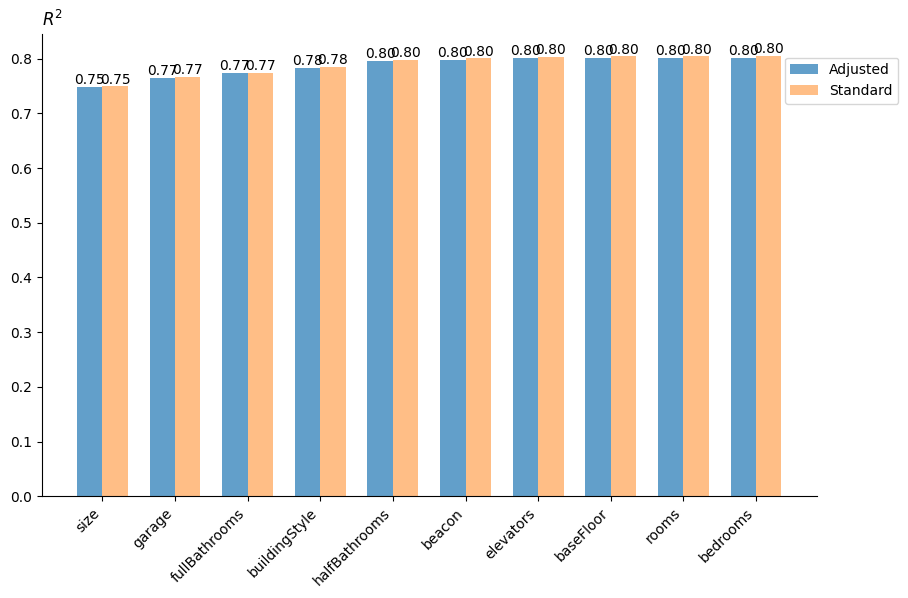

In [12]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define width for bars and positions for each pair of bars
bar_width = 0.35
x = np.arange(len(ordered_variables))

# Plot adjusted R-squared and R-squared bars side by side
bars_adj = ax.bar(x - bar_width / 2, optimal_adj_rsqr, width=bar_width, label="Adjusted", alpha=0.7)
bars_rs = ax.bar(x + bar_width / 2, optimal_rsqr, width=bar_width, label="Standard", alpha=0.5)

# Add labels, title, and angle the x-axis labels
ax.set_title(r"$R^2$", loc='left')
ax.set_xticks(x)
ax.set_xticklabels(ordered_variables, rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(.95, 0.9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display values above each bar
for bar in bars_adj:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bars_rs:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()